## Задача 4 Ансамбли

**Автор**: Степырев Даниил Федорович

**Группа**: 22.М05

**Выполненные задачи**:
- [✓] Найти данные размера хотя бы 10000, на которых можно решить задачу классификации или регрессии.
- [✓] Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- [✓] Самостоятельно реализуйте алгоритмы **Bagging** и **AdaBoost**, которые позволят обучить ансамбли каких-то простых моделей, например деревьев принятия решений.
- [✓] Обучите ансамбли для каких-то простых моделей, используя свои две реализации, а также реализации из **sklearn** (**Bagging**, **Random Forest**, **AdaBoost**, **Gradient Tree Boosting**, **Histogram-Based Gradient Boosting**).
- [✓] При обучении использовать **подбор гиперпараметров**, **кросс-валидацию**.
- [✓] Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества, построить матрицы ошибок.
- [✓] * (**+2 балла**) Также добавить в сравнение модели из библиотек **XGBoost**, **LightGBM** и **CatBoost**.
- [✓] * (**+3 балла**) Для подбора гиперпараметров использовать фреймворк **Optuna**.

### Данные, на которых решается задача

В задаче используется датасет, содержащий информацию о задержках самолётов. Размер датасета --- 539382.

Описание датасета:

- **Flight** --- номер полёта;

- **Time** --- планируемое время вылета;

- **Length** --- продолжительность задержки;

- **Airline** --- компания-перевозчик;

- **AirportFrom** --- аэропорт, откуда самолёт вылетает;

- **AirportTo** --- аэропорт назначения;

- **DayOfWeek** --- день недели, в который произовдился вылет;

- **Class** --- класс перелёта.

Целевой признак --- **class**.

### Считывание данных

Подключаем использумые библиотеки:

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# устанавливаем точность чисел с плавающей точкой
%precision %.4f

import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

Считыванием обучающую выборку:

In [2]:
df = pd.read_csv('Dataset/airlines_delay.csv')
df.head()

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,2313.0,1296.0,141.0,DL,ATL,HOU,1,0
1,6948.0,360.0,146.0,OO,COS,ORD,4,0
2,1247.0,1170.0,143.0,B6,BOS,CLT,3,0
3,31.0,1410.0,344.0,US,OGG,PHX,6,0
4,563.0,692.0,98.0,FL,BMI,ATL,4,0


Общее количество пропущенных значений:

In [3]:
df.isnull().sum()

Flight         0
Time           0
Length         0
Airline        0
AirportFrom    0
AirportTo      0
DayOfWeek      0
Class          0
dtype: int64

## Разведочный анализ (EDA)

Рассмотрим, сколько значений принимает целевой признак **class**:

In [4]:
df['Class'].value_counts()

0    299118
1    240264
Name: Class, dtype: int64

Построим график:

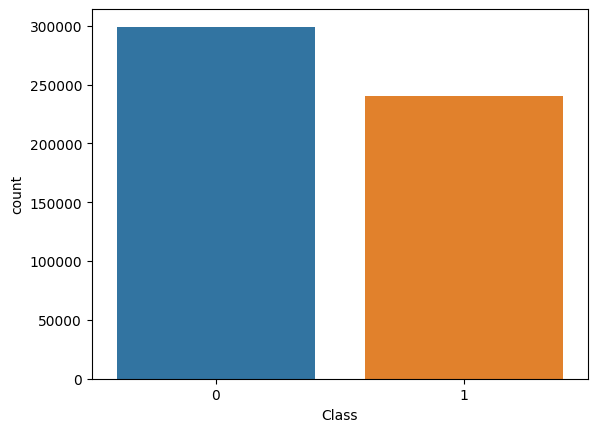

In [5]:
sns.countplot(x="Class", data=df)
plt.show()

Видим, что в датасете большее число задержек происходило для 0 класса полёта.

Введём дополнительные функции для удобного отображения графиков:

In [6]:
def show_class_crosstab(x_param, x_param_name = "", figsize_number = 20):
    pd.crosstab(df[x_param], df['Сlass']).plot(kind="bar", figsize=(figsize_number, 6))
    plt.xlabel(x_param_name)
    plt.ylabel('Число задержек в классе')
    plt.show()
    
def show_barplot(x_param_name):
    plt.figure(figsize=(20,5))
    plt.grid(axis="x")
    plt.xticks(rotation = 90)
    plt.title('Принадлежность к классу относительно признака ' + x_param_name, fontsize = 20)
    plt.xlabel(x_param_name, fontsize= 15)
    plt.ylabel('Class', fontsize= 15)
    sns.barplot(x = df[x_param_name], y = df['Class'])
    plt.show()

### Количественный признак Flight

Выясним, какие значения принимает признак **Flight** в датасете:

In [7]:
df['Flight'].describe()

count    539382.000000
mean       2427.927988
std        2067.431700
min           1.000000
25%         712.000000
50%        1809.000000
75%        3745.000000
max        7814.000000
Name: Flight, dtype: float64

Видим, что в датасете этот признак принимает значения от 1 до 7814.

Выясним число уникальных значений:

In [8]:
df['Flight'].unique().size

6585

Видим, что признак **Flight** принимает больше число уникальных значений. Запомним это.

### Количественный признак Time

Выясним, какие значения принимает признак **Time** в датасете:

In [9]:
df['Time'].describe()

count    539382.000000
mean        802.728161
std         278.045546
min          10.000000
25%         565.000000
50%         795.000000
75%        1035.000000
max        1439.000000
Name: Time, dtype: float64

Видим, что самый ранний вылет с задержкой производился в значение 10, а самый поздний в 1439. Среднее значения время вылета с задержкой --- 803.

Посмотрим, какое среднее время вылета с задержкой для полётов разных классов:

In [10]:
df.groupby('Class').mean()["Time"]

Class
0    765.235138
1    849.405308
Name: Time, dtype: float64

<Axes: xlabel='Class'>

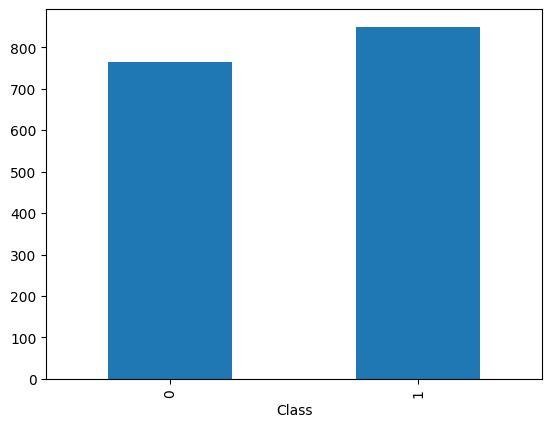

In [11]:
df.groupby('Class').mean()["Time"].plot.bar()

Видим, что для 0 класса среднее время вылета с задержкой составляло 765, а для класса 1 --- 849.


### Количественный признак Length

Выясним, какие значения принимает признак **Length** в датасете:

In [12]:
df['Length'].describe()

count    539382.000000
mean        132.202104
std          70.117045
min           0.000000
25%          81.000000
50%         115.000000
75%         162.000000
max         655.000000
Name: Length, dtype: float64

Видим, что минимальное время задержки составляло 0 минут, а максимальное значени --- 655 минут. Среднее значение задержки вылета --- 132 минуты.

Посмотрим, какое среднее время задержки вылета для полётов разных классов:

In [13]:
df.groupby('Class').mean()["Length"]

Class
0    129.657760
1    135.369697
Name: Length, dtype: float64

<Axes: xlabel='Class'>

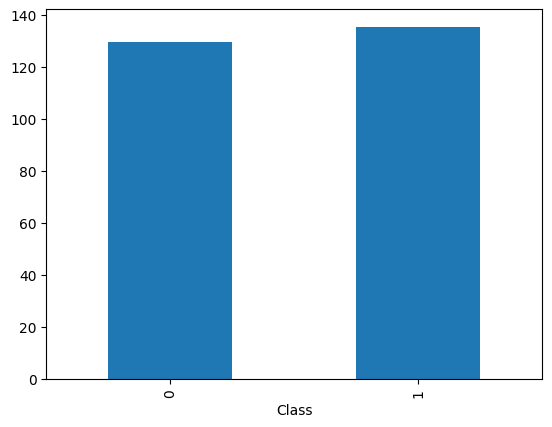

In [14]:
df.groupby('Class').mean()["Length"].plot.bar()

Видим, что для 0 класса это значение составляет 130 минут, а для 1 класса --- 135 минут.

### Категориальный признак Airline

Выясним, какие значения принимает признак **Airline** в датасете:

In [15]:
df['Airline'].describe()

count     539382
unique        18
top           WN
freq       94097
Name: Airline, dtype: object

Видим, что в датасете значение признака **Airline** принимает 18 уникальных значений.

Построим график:

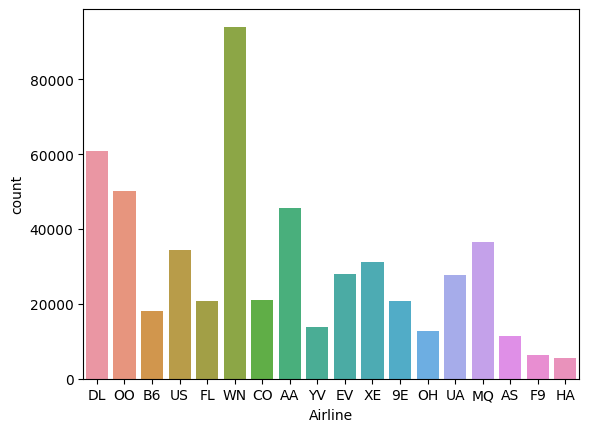

In [16]:
sns.countplot(x="Airline", data=df)
plt.show()

Видим, что в большего всего перелётов компании WN, а меньше всего --- компании HA.

Построим график принадлежности к классу относительно компании:

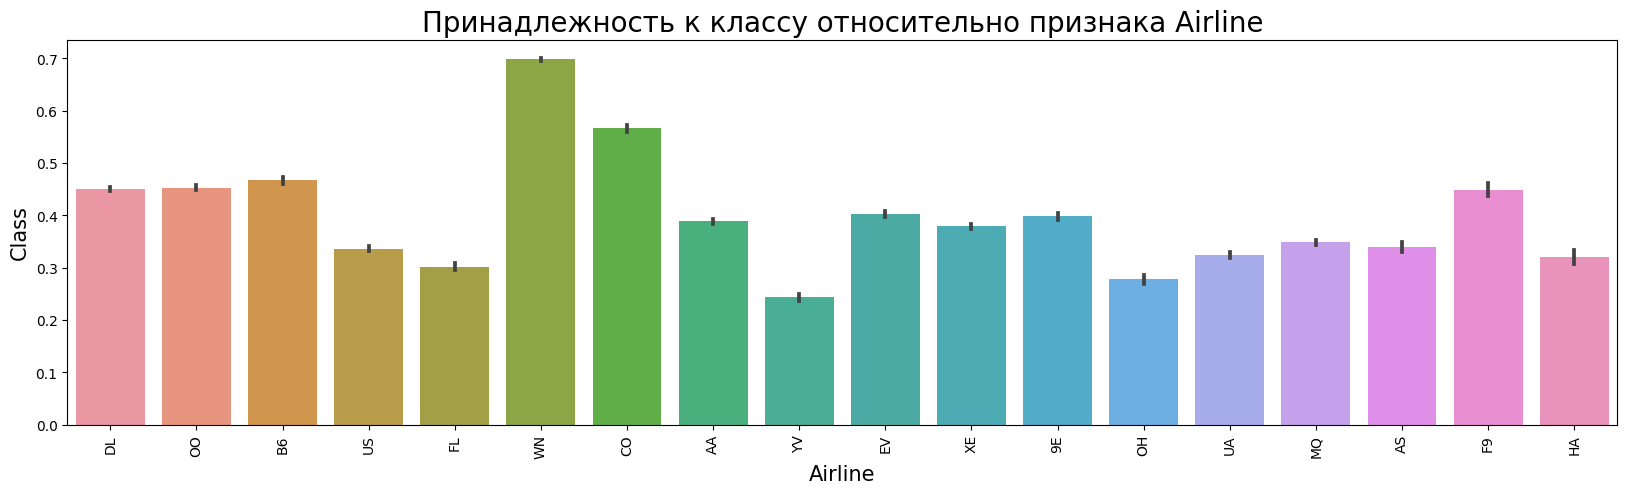

In [17]:
show_barplot("Airline")

Посмотрим, к каким классам относятся различные компании:

In [18]:
df.groupby('Airline').mean()["Class"]

Airline
9E    0.397660
AA    0.388470
AS    0.339290
B6    0.467038
CO    0.566199
DL    0.450476
EV    0.402208
F9    0.449040
FL    0.301292
HA    0.320186
MQ    0.348104
OH    0.277276
OO    0.452899
UA    0.323907
US    0.335971
WN    0.697759
XE    0.378944
YV    0.242914
Name: Class, dtype: float64

<Axes: xlabel='Airline'>

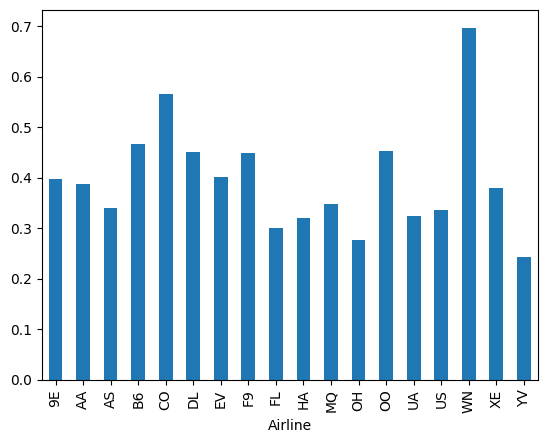

In [19]:
df.groupby('Airline').mean()["Class"].plot.bar()

### Категориальный признак AirportFrom

Выясним, какие значения принимает признак **AirportFrom** в датасете:

In [20]:
df['AirportFrom'].describe()

count     539382
unique       293
top          ATL
freq       34449
Name: AirportFrom, dtype: object

Видим, что признак **AirportFrom** принимает большое число уникальных значений. Чаще всего в качестве аэропорта вылета встречается ATL.

### Категориальный признак AirportTo

Выясним, какие значения принимает признак **AirportTo** в датасете:

In [21]:
df['AirportTo'].describe()

count     539382
unique       293
top          ATL
freq       34440
Name: AirportTo, dtype: object

Видим, что признак **AirportFrom** принимает большое число уникальных значений. Чаще всего в качестве аэропорта прилёта встречается ATL.

### Категориальный признак DayOfWeek

Выясним, какие значения принимает признак **DayOfWeek** в датасете:

In [22]:
df['DayOfWeek'].describe()

count    539382.000000
mean          3.929666
std           1.914666
min           1.000000
25%           2.000000
50%           4.000000
75%           5.000000
max           7.000000
Name: DayOfWeek, dtype: float64

Видим, что признак **DayOfWeek** принимает значения от 1 до 7. Чаще всего задержки авиаперелётов происходили в 4 день.

Построим график:

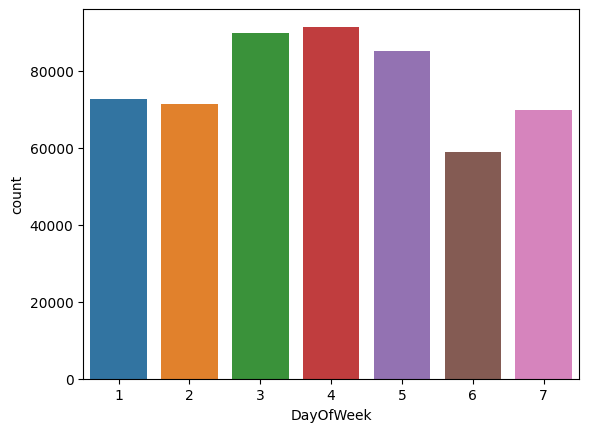

In [23]:
sns.countplot(x="DayOfWeek", data=df)
plt.show()

Из графика также видно, что задержки авиаперелётов чаще происходили в третий и четвёртый день недели, а реже всего --- в шестой день.

Выясним среднее значение классов для различных дней недели:

In [24]:
df.groupby('DayOfWeek').mean()["Class"]

DayOfWeek
1    0.467644
2    0.447337
3    0.470818
4    0.451025
5    0.416613
6    0.400553
7    0.453541
Name: Class, dtype: float64

Видим, что для всех дней недели преобладает 0 класс.

<Axes: xlabel='DayOfWeek'>

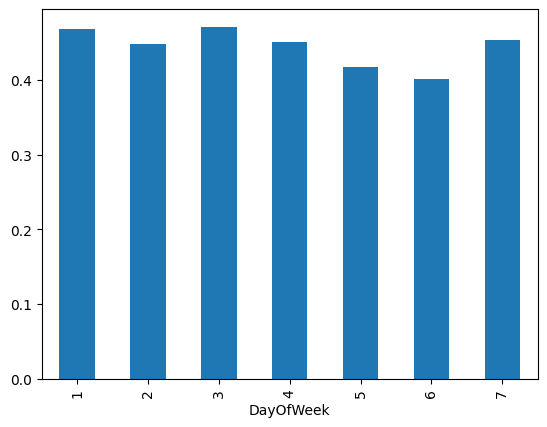

In [25]:
df.groupby('DayOfWeek').mean()["Class"].plot.bar()

## Выводы

- **Flight** --- принимает значения от 1 до 7814. Признак имеет большое число уникальных значений;

- **Time** --- cамый ранний вылет с задержкой производился в значение 10, а самый поздний в 1439. Среднее значения время вылета с задержкой --- 803. Для 0 класса среднее время вылета с задержкой составляло 765, а для класса 1 --- 849;

- **Length** --- минимальное время задержки составляло 0 минут, а максимальное значени --- 655 минут. Среднее значение задержки вылета --- 132 минуты. Для 0 класса среднее значение задержки составляет 130 минут, а для 1 класса --- 135 минут;

- **Airline** --- большего всего перелётов компании WN, а меньше всего --- компании HA;

- **AirportFrom** --- чаще всего в качестве аэропорта вылета встречается ATL. Признак имеет большое число уникальных значений;

- **AirportTo** --- чаще всего в качестве аэропорта вылета встречается ATL. Признак имеет большое число уникальных значений;

- **DayOfWeek** --- день недели, в который произовдился вылет;

- **Class** --- задержки авиаперелётов происходили чаще в третий и четвёртый день недели, а реже всего --- в шестой день.

## Feature Engineering

Преобразуем количественные признаки в категориальные:

### Новый признак категории полёта

In [26]:
df['Flight_Category'] = pd.qcut(df['Flight'], 8)
df.groupby(['Flight_Category', 'Class'])['Class'].count().to_frame().style.background_gradient(cmap='summer_r')

In [27]:
df['Flight_Category'] = 0
df.loc[df['Flight'] <= 351.0, 'Flight_Category'] = 0
df.loc[(df['Flight'] > 351.0) & (df['Flight'] <= 712.0), 'Flight_Category'] = 1
df.loc[(df['Flight'] > 712.0) & (df['Flight'] <= 1201.0), 'Flight_Category'] = 2
df.loc[(df['Flight'] > 1201.0) & (df['Flight'] <= 1809.0), 'Flight_Category'] = 3
df.loc[(df['Flight'] > 1809.0) & (df['Flight'] <= 2608.0), 'Flight_Category'] = 4
df.loc[(df['Flight'] > 2608.0) & (df['Flight'] <= 3745.0), 'Flight_Category'] = 5
df.loc[(df['Flight'] > 3745.0) & (df['Flight'] <= 5440.0), 'Flight_Category'] = 6
df.loc[(df['Flight'] > 5440.0), 'Flight_Category'] = 7

### Новый признак категории времени вылета

In [28]:
df['Time_Category'] = pd.qcut(df['Time'], 8)
df.groupby(['Time_Category', 'Class'])['Class'].count().to_frame().style.background_gradient(cmap='summer_r')

In [29]:
df['Time_Category'] = 0
df.loc[df['Time'] <= 450.0, 'Time_Category'] = 0
df.loc[(df['Time'] > 450.0) & (df['Time'] <= 565.0), 'Time_Category'] = 1
df.loc[(df['Time'] > 565.0) & (df['Time'] <= 680.0), 'Time_Category'] = 2
df.loc[(df['Time'] > 680.0) & (df['Time'] <= 795.0), 'Time_Category'] = 3
df.loc[(df['Time'] > 795.0) & (df['Time'] <= 915.0), 'Time_Category'] = 4
df.loc[(df['Time'] > 915.0) & (df['Time'] <= 1035.0), 'Time_Category'] = 5
df.loc[(df['Time'] > 1035.0) & (df['Time'] <= 1155.0), 'Time_Category'] = 6
df.loc[df['Time'] > 1155.0, 'Time_Category'] = 7

### Новый признак категории времени задержки

In [30]:
df['Length_Category'] = pd.qcut(df['Length'], 8)
df.groupby(['Length_Category', 'Class'])['Class'].count().to_frame().style.background_gradient(cmap='summer_r')

In [31]:
df['Length_Category'] = 0
df.loc[df['Length'] <= 67.0, 'Length_Category'] = 0
df.loc[(df['Length'] > 67.0) & (df['Length'] <= 81.0), 'Length_Category'] = 1
df.loc[(df['Length'] > 81.0) & (df['Length'] <= 97.0), 'Length_Category'] = 2
df.loc[(df['Length'] > 97.0) & (df['Length'] <= 115.0), 'Length_Category'] = 3
df.loc[(df['Length'] > 115.0) & (df['Length'] <= 135.0), 'Length_Category'] = 4
df.loc[(df['Length'] > 135.0) & (df['Length'] <= 162.0), 'Length_Category'] = 5
df.loc[(df['Length'] > 162.0) & (df['Length'] <= 208.0), 'Length_Category'] = 6
df.loc[df['Length'] > 208.0, 'Length_Category'] = 7

In [32]:
# Удаляем количественные признаки, которые преобразовали в категориальные.
df.drop(['Flight', 'Time', 'Length'], axis = 1, inplace = True)

df

,Airline,AirportFrom,AirportTo,DayOfWeek,Class,Flight_Category,Time_Category,Length_Category
0,DL,ATL,HOU,1,0,4,7,5
1,OO,COS,ORD,4,0,7,0,5
2,B6,BOS,CLT,3,0,3,7,5
3,US,OGG,PHX,6,0,0,7,7
4,FL,BMI,ATL,4,0,1,3,3
...,...,...,...,...,...,...,...,...
539377,OO,GEG,SEA,5,1,7,1,1
539378,WN,LAS,DEN,4,1,3,1,3
539379,EV,CAE,ATL,2,1,6,4,1
539380,WN,BWI,BUF,4,1,1,3,0


In [33]:
unique_airline = pd.unique(df["Airline"])
df['Airline'].replace(unique_airline, range(0, len(unique_airline)), inplace = True)

unique_airport_from = pd.unique(df["AirportFrom"])
df['AirportFrom'].replace(unique_airport_from, range(0, len(unique_airport_from)), inplace = True)

unique_airport_to = pd.unique(df["AirportTo"])
df['AirportTo'].replace(unique_airport_to, range(0, len(unique_airport_to)), inplace = True)
df

,Airline,AirportFrom,AirportTo,DayOfWeek,Class,Flight_Category,Time_Category,Length_Category
0,0,0,0,1,0,4,7,5
1,1,1,1,4,0,7,0,5
2,2,2,2,3,0,3,7,5
3,3,3,3,6,0,0,7,7
4,4,4,4,4,0,1,3,3
...,...,...,...,...,...,...,...,...
539377,1,96,51,5,1,7,1,1
539378,5,49,12,4,1,3,1,3
539379,9,74,4,2,1,6,4,1
539380,5,8,33,4,1,1,3,0


<Axes: >

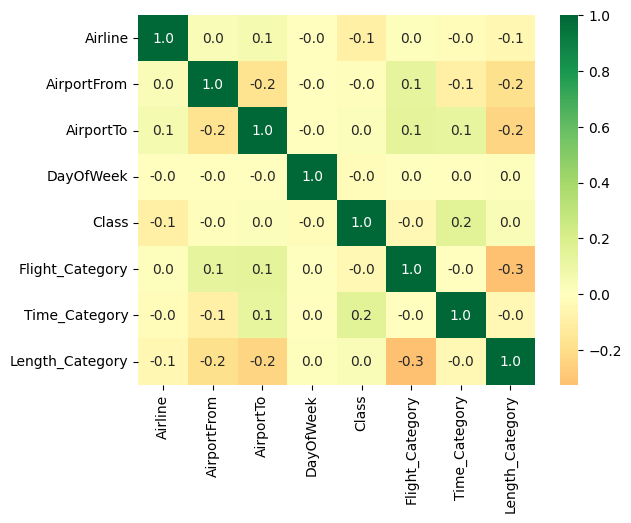

In [34]:
sns.heatmap(df.corr(), center=0, annot=True, fmt='.1f', cmap="RdYlGn")

## Самостоятельная реализация алгоритмов ансамблей

### Bagging

Подготим класс ``BaggingDtClassifier``, реализующий алгоритм **Bagging**:

In [35]:
from sklearn.tree import DecisionTreeClassifier

class BaggingDtClassifier:
    def __init__(self, estimators_number = 15, samples_number = 1):
        self.estimators_number = estimators_number
        self.samples_number = samples_number

    def fit(self, x, y):
        self.estimators = []
        
        for i in range(self.estimators_number):
            sample_index = np.random.choice(self.samples_number, size = len(x))
            x_sample = x[sample_index]
            y_sample = y[sample_index]
            
            estimator = DecisionTreeClassifier()
            estimator.fit(x_sample, y_sample)

            self.estimators.append(estimator)

    def predict(self, x):
        predicted = np.zeros(len(x))
        for estimator in self.estimators:
            predicted += estimator.predict(x)
            
        predicted /= self.estimators_number
        return np.round(predicted)

Подготим класс ``AdaBoostDtClassifier``, реализующий алгоритм **AdaBoost**:

In [36]:
class AdaBoostDtClassifier:
    def __init__(self, estimators_number = 50, learning_rate = 1):
        self.estimators_number = estimators_number
        self.learning_rate = learning_rate
        
        self.estimators = []
        self.weights = np.zeros(estimators_number)

    def fit(self, x, y):
        w = np.ones(len(x))
        w /= len(x)
        
        for i in range(self.estimators_number):
            estimator = DecisionTreeClassifier()
            estimator.fit(x, y, sample_weight = w)

            error, incorrect = self.calculate_error(x, y, w, estimator)
            
            weight = self.calculate_weight(error, self.learning_rate)
            self.weights[i] = weight

            w *= np.exp(weight * incorrect * ((w > 0) | (weight < 0)))
            w /= np.sum(w)

            self.estimators.append(estimator)
            
    def calculate_error(self, x, y, w, estimator):
        y_pred = estimator.predict(x)
        
        incorrect = y_pred != y
        estimator_error = np.sum(w[incorrect])
        
        return (estimator_error, incorrect)
    
    def calculate_weight(self, error, learning_rate):
        return 1 if error <= 0 else learning_rate * np.log((1 - error) / error)

    def get_params(self, deep=True):
        return {'n_estimators': self.estimators_number, 'learning_rate': self.learning_rate}

    def predict(self, x):
        y_pred = np.zeros(len(x))
        for i, estimator in enumerate(self.estimators):
            y_pred += self.weights[i] * estimator.predict(x)
            
        return np.sign(y_pred)

## Обучение ансамблей для моделей

Подготовим данные:

In [37]:
from sklearn.model_selection import train_test_split

x = df.drop('Class', axis = 1).values
y = df['Class'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 42)

n_trials = 25

Для подбора гиперпараметров используем фреймворк **Optuna**.

### Обучение собственной реализации Bagging

In [38]:
from sklearn.metrics import accuracy_score
import time
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    estimators_number = trial.suggest_int('Estimators number', 1, 25)
    samples_number = trial.suggest_int('Samples number', 1, 20)
    
    model = BaggingDtClassifier(estimators_number, samples_number)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = n_trials)

print(f'Best parameters: {study.best_trial.params}')
print(f'Best accuracy: {study.best_value}')

estimators_number_best = study.best_trial.params['Estimators number']
samples_number_best = study.best_trial.params['Samples number']

model = BaggingDtClassifier(estimators_number_best, samples_number_best)

start = time.time()
model.fit(x_train, y_train)
end = time.time()

bagging_pred = model.predict(x_test)
bagging_accuracy = accuracy_score(y_test, bagging_pred)
bagging_time = end - start

print(f'Model accuracy: {bagging_accuracy}')
print(f'Model time: {bagging_time}')

Best parameters: {'Estimators number': 18, 'Samples number': 7}
Best accuracy: 0.5633710771113264
Model accuracy: 0.5440573248112425
Model time: 0.8946378231048584


### Обучение собственной реализации AdaBoost

In [39]:
def objective(trial):
    estimators_number = trial.suggest_int('Estimators number', 1, 25)
    learning_rate = trial.suggest_int('Learning rate', 1, 10)
    
    model = AdaBoostDtClassifier(estimators_number, learning_rate / 10)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = n_trials)

print(f'Best parameters: {study.best_trial.params}')
print(f'Best accuracy: {study.best_value}')

estimators_number_best = study.best_trial.params['Estimators number']
learning_rate_best = study.best_trial.params['Learning rate']

model = AdaBoostDtClassifier(estimators_number_best, learning_rate_best)

start = time.time()
model.fit(x_train, y_train)
end = time.time()

adaboost_pred = model.predict(x_test)
adaboost_accuracy = accuracy_score(y_test, adaboost_pred)
adaboost_time = end - start

print(f'Model accuracy: {adaboost_accuracy}')
print(f'Model time: {adaboost_time}')

Best parameters: {'Estimators number': 1, 'Learning rate': 10}
Best accuracy: 0.6057528748151821
Model accuracy: 0.6054006201536015
Model time: 0.9778754711151123


### Обучение sklearn реализации Bagging

In [40]:
from sklearn.ensemble import BaggingClassifier

def objective(trial):
    estimators_number = trial.suggest_int('Estimators number', 1, 25)
    samples_number = trial.suggest_int('Samples number', 1, 20)
    features_number = trial.suggest_int('Features number', 2, 10)
    model = BaggingClassifier(
        n_estimators = estimators_number,
        max_samples = samples_number / 20,
        max_features = features_number / 10,
        base_estimator = DecisionTreeClassifier())
    
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = n_trials)

print(f'Best parameters: {study.best_trial.params}')
print(f'Best accuracy: {study.best_value}')

estimators_number_best = study.best_trial.params['Estimators number']
samples_number_best = study.best_trial.params['Samples number']
features_number_best = study.best_trial.params['Features number']

model = BaggingClassifier(
    n_estimators = estimators_number_best,
    max_samples = samples_number_best / 20,
    max_features = features_number_best / 12,
    base_estimator = DecisionTreeClassifier())

start = time.time()
model.fit(x_train, y_train)
end = time.time()

sklearn_bagging_pred = model.predict(x_test)
sklearn_bagging_accuracy = accuracy_score(y_test, sklearn_bagging_pred)
sklearn_bagging_time = end - start

print(f'Model accuracy: {sklearn_bagging_accuracy}')
print(f'Model time: {sklearn_bagging_time}')

Best parameters: {'Estimators number': 22, 'Samples number': 16, 'Features number': 6}
Best accuracy: 0.6617474612172253
Model accuracy: 0.6570337376537059
Model time: 4.007788419723511


### Обучение sklearn реализации AdaBoost

In [41]:
from sklearn.ensemble import AdaBoostClassifier

def objective(trial):
    estimators_number = trial.suggest_int('Estimators number', 1, 10)
    learning_rate = trial.suggest_int('Learning rate', 1, 5)
    
    model = AdaBoostClassifier(
        n_estimators = estimators_number,
        learning_rate = learning_rate / 10,
        base_estimator = DecisionTreeClassifier())
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = n_trials)

print(f'Best parameters: {study.best_trial.params}')
print(f'Best accuracy: {study.best_value}')

estimators_number_best = study.best_trial.params['Estimators number']
learning_rate_best = study.best_trial.params['Learning rate']

model = AdaBoostClassifier(
    n_estimators = estimators_number_best,
    learning_rate = learning_rate_best / 10,
    base_estimator = DecisionTreeClassifier())

start = time.time()
model.fit(x_train, y_train)
end = time.time()

sklearn_adaboost_pred = model.predict(x_test)
sklearn_adaboost_accuracy = accuracy_score(y_test, adaboost_pred)
sklearn_adaboost_time = end - start

print(f'Model accuracy: {sklearn_adaboost_accuracy}')
print(f'Model time: {sklearn_adaboost_time}')

Best parameters: {'Estimators number': 3, 'Learning rate': 1}
Best accuracy: 0.6086033566161305
Model accuracy: 0.6054006201536015
Model time: 3.4949445724487305


### Обучение sklearn реализации Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier

def objective(trial):
    estimators_number = trial.suggest_int('Estimators number', 1, 100)
    samples_number = trial.suggest_int('Samples number', 1, 20)
    features_number = trial.suggest_int('Features number', 2, 10)
    rf = RandomForestClassifier(
        n_estimators = estimators_number,
        max_samples = samples_number / 20,
        max_features = features_number / 10,
        max_depth = 4,
        random_state = 42)
    rf.fit(x_train, y_train)
    y_pred = rf.predict(x_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = n_trials)

print(f'Best parameters: {study.best_trial.params}')
print(f'Best accuracy: {study.best_value}')

estimators_number_best = study.best_trial.params['Estimators number']
samples_number_best = study.best_trial.params['Samples number']
features_number_best = study.best_trial.params['Features number']

model = RandomForestClassifier(
    n_estimators = estimators_number_best,
    max_samples = samples_number_best / 20,
    max_features = features_number_best / 10,
    max_depth = 4,
    random_state = 42)

start = time.time()
model.fit(x_train, y_train)
end = time.time()

sklearn_rf_pred = model.predict(x_test)
sklearn_rf_accuracy = accuracy_score(y_test, sklearn_rf_pred)
sklearn_rf_time = end - start

print(f'Model accuracy: {sklearn_rf_accuracy}')
print(f'Model time: {sklearn_rf_time}')

Best parameters: {'Estimators number': 6, 'Samples number': 11, 'Features number': 8}
Best accuracy: 0.6353469013177105
Model accuracy: 0.6353469013177105
Model time: 0.7320864200592041


### Обучение sklearn реализации Gradient Tree Boosting

In [43]:
from sklearn.ensemble import GradientBoostingClassifier

def objective(trial):
    estimators_number = trial.suggest_int('Estimators number', 1, 25)
    depth = trial.suggest_int('Depth', 1, 10)
    features_number = trial.suggest_int('Features number', 2, 10)
    gb = GradientBoostingClassifier(
        n_estimators = estimators_number,
        max_depth = depth,
        max_features = features_number / 10,
        random_state = 42)
    
    gb.fit(x_train, y_train)
    y_pred = gb.predict(x_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = n_trials)

print(f'Best parameters: {study.best_trial.params}')
print(f'Best accuracy: {study.best_value}')

estimators_number_best = study.best_trial.params['Estimators number']
depth_best = study.best_trial.params['Depth']
features_number_best = study.best_trial.params['Features number']

model = GradientBoostingClassifier(
    n_estimators = estimators_number_best,
    max_depth = depth_best,
    max_features = features_number_best / 10,
    random_state = 42)

start = time.time()
model.fit(x_train, y_train)
end = time.time()

sklearn_gb_pred = model.predict(x_test)
sklearn_gb_accuracy = accuracy_score(y_test, sklearn_gb_pred)
sklearn_gb_time = end - start

print(f'Model accuracy: {sklearn_gb_accuracy}')
print(f'Model time: {sklearn_gb_time}')

Best parameters: {'Estimators number': 25, 'Depth': 10, 'Features number': 8}
Best accuracy: 0.6598564098761083
Model accuracy: 0.6598564098761083
Model time: 14.411716938018799


### Обучение sklearn реализации Histogram-Based Gradient Boosting

In [44]:
from sklearn.ensemble import HistGradientBoostingClassifier

def objective(trial):
    learning_rate = trial.suggest_int('Learning rate', 1, 10)
    iterations_number = trial.suggest_int('Iterations number', 1, 15)
    leaf_nodes_number = trial.suggest_int('Leaf nodes number', 2, 32)
    depth = trial.suggest_int('Depth', 1, 10)
    hgb = HistGradientBoostingClassifier(
        learning_rate = learning_rate / 10,
        max_iter = iterations_number,
        max_depth = depth,
        max_leaf_nodes = leaf_nodes_number,
        random_state = 42)
    
    hgb.fit(x_train, y_train)
    y_pred = hgb.predict(x_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = n_trials)

print(f'Best parameters: {study.best_trial.params}')
print(f'Best accuracy: {study.best_value}')

learning_rate_best = study.best_trial.params['Learning rate']
iterations_number_best = study.best_trial.params['Iterations number']
depth_best = study.best_trial.params['Depth']
leaf_nodes_number_best = study.best_trial.params['Leaf nodes number']

model = HistGradientBoostingClassifier(
    learning_rate = learning_rate_best / 10,
    max_iter = iterations_number_best,
    max_depth = depth_best,
    max_leaf_nodes = leaf_nodes_number_best,
    random_state = 42)

start = time.time()
model.fit(x_train, y_train)
end = time.time()

sklearn_hgb_pred = model.predict(x_test)
sklearn_hgb_accuracy = accuracy_score(y_test, sklearn_hgb_pred)
sklearn_hgb_time = end - start

print(f'Model accuracy: {sklearn_hgb_accuracy}')
print(f'Model time: {sklearn_hgb_time}')

Best parameters: {'Learning rate': 7, 'Iterations number': 15, 'Leaf nodes number': 24, 'Depth': 7}
Best accuracy: 0.6531172220085004
Model accuracy: 0.6531172220085004
Model time: 0.3488175868988037


### Обучение XGBoost реализации XGBClassifier

In [45]:
from xgboost import XGBClassifier

def objective(trial):
    estimators_number = trial.suggest_int('Estimators number', 1, 25)
    leaves_number = trial.suggest_int('Leaves number', 1, 20)
    depth = trial.suggest_int('Depth', 1, 10)
    xgb = XGBClassifier(
        n_estimators = estimators_number,
        max_leaves = leaves_number,
        max_depth = depth,
        random_state = 42)
    
    xgb.fit(x_train, y_train)
    y_pred = xgb.predict(x_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = n_trials)

print(f'Best parameters: {study.best_trial.params}')
print(f'Best accuracy: {study.best_value}')

estimators_number_best = study.best_trial.params['Estimators number']
leaves_number_best = study.best_trial.params['Leaves number']
depth_best = study.best_trial.params['Depth']

model = XGBClassifier(
    n_estimators = estimators_number_best,
    max_leaves = leaves_number_best,
    max_depth = depth_best,
    random_state = 42)

start = time.time()
model.fit(x_train, y_train)
end = time.time()

xgboost_pred = model.predict(x_test)
xgboost_accuracy = accuracy_score(y_test, xgboost_pred)
xgboost_time = end - start

print(f'Model accuracy: {sklearn_gb_accuracy}')
print(f'Model time: {xgboost_time}')

Best parameters: {'Estimators number': 25, 'Leaves number': 1, 'Depth': 10}
Best accuracy: 0.6630823209874255
Model accuracy: 0.6598564098761083
Model time: 1.4649121761322021


### Обучение LightGBM реализации LGBMClassifier

In [46]:
from lightgbm import LGBMClassifier

def objective(trial):
    estimators_number = trial.suggest_int('Estimators number', 1, 25)
    learning_rate = trial.suggest_int('Learning rate', 1, 10)
    depth = trial.suggest_int('Depth', 1, 10)
    xgb = LGBMClassifier(
        n_estimators = estimators_number,
        learning_rate = learning_rate / 10,
        max_depth = depth,
        random_state = 42)
    
    xgb.fit(x_train, y_train)
    y_pred = xgb.predict(x_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = n_trials)

print(f'Best parameters: {study.best_trial.params}')
print(f'Best accuracy: {study.best_value}')

estimators_number_best = study.best_trial.params['Estimators number']
learning_rate_best = study.best_trial.params['Learning rate']
depth_best = study.best_trial.params['Depth']

model = LGBMClassifier(
    n_estimators = estimators_number_best,
    learning_rate = learning_rate_best / 10,
    max_depth = depth_best,
    random_state = 42)

start = time.time()
model.fit(x_train, y_train)
end = time.time()

lightgbm_pred = model.predict(x_test)
lightgbm_accuracy = accuracy_score(y_test, lightgbm_pred)
lightgbm_time = end - start

print(f'Model accuracy: {lightgbm_accuracy}')
print(f'Model time: {lightgbm_time}')

Best parameters: {'Estimators number': 25, 'Learning rate': 6, 'Depth': 8}
Best accuracy: 0.6565934193267301
Model accuracy: 0.6565934193267301
Model time: 0.19122576713562012


### Обучение CatBoost реализации CatBoostClassifier

In [47]:
from catboost import CatBoostClassifier

def objective(trial):
    estimators_number = trial.suggest_int('Estimators number', 1, 25)
    learning_rate = trial.suggest_int('Learning rate', 1, 10)
    depth = trial.suggest_int('Depth', 1, 10)
    xgb = CatBoostClassifier(
        n_estimators = estimators_number,
        learning_rate = learning_rate / 10,
        max_depth = depth,
        random_state = 42,
        verbose = False)
    
    xgb.fit(x_train, y_train)
    y_pred = xgb.predict(x_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = n_trials)

print(f'Best parameters: {study.best_trial.params}')
print(f'Best accuracy: {study.best_value}')

estimators_number_best = study.best_trial.params['Estimators number']
learning_rate_best = study.best_trial.params['Learning rate']
depth_best = study.best_trial.params['Depth']

model = CatBoostClassifier(
    n_estimators = estimators_number_best,
    learning_rate = learning_rate_best / 10,
    max_depth = depth_best,
    random_state = 42,
    verbose = False)

start = time.time()
model.fit(x_train, y_train)
end = time.time()

catboost_pred = model.predict(x_test)
catboost_accuracy = accuracy_score(y_test, catboost_pred)
catboost_time = end - start

print(f'Model accuracy: {catboost_accuracy}')
print(f'Model time: {catboost_time}')

Best parameters: {'Estimators number': 25, 'Learning rate': 8, 'Depth': 10}
Best accuracy: 0.6554578615361084
Model accuracy: 0.6554578615361084
Model time: 1.8975682258605957


## Сравнение результатов обучения моделей

In [48]:
result_dict = {
    'Accuracy': [bagging_accuracy, sklearn_bagging_accuracy, adaboost_accuracy, sklearn_adaboost_accuracy,
                 sklearn_rf_accuracy, sklearn_gb_accuracy, sklearn_hgb_accuracy, xgboost_accuracy,
                 lightgbm_accuracy, catboost_accuracy],
    'Time': [bagging_time, sklearn_bagging_time, adaboost_time, sklearn_adaboost_time, sklearn_rf_time,
             sklearn_gb_time, sklearn_hgb_time, xgboost_time, lightgbm_time, catboost_time]
}

algorithms = [
    'My Bagging', 'Sklearn Bagging', 'My AdaBoost', 'Sklearn AdaBoost', 'Sklearn Random Forest',
    'Sklearn Gradient Tree Boosting', 'Sklearn Histogram-Based Gradient Boosting',
    'XGBoost', 'LightGBM', 'CatBoost'
]

result = pd.DataFrame(result_dict, index = algorithms)
result

,Accuracy,Time
My Bagging,0.544057,0.894638
Sklearn Bagging,0.657034,4.007788
My AdaBoost,0.605401,0.977875
Sklearn AdaBoost,0.605401,3.494945
Sklearn Random Forest,0.635347,0.732086
Sklearn Gradient Tree Boosting,0.659856,14.411717
Sklearn Histogram-Based Gradient Boosting,0.653117,0.348818
XGBoost,0.663082,1.464912
LightGBM,0.656593,0.191226
CatBoost,0.655458,1.897568


**Выводы**:
- Собственные реализации Bagging и AdaBoost менее точны, чем реализации библиотеки sklearn;
- Собственные реализиции обучаются быстрее, чем реализации библиотеки sklearn;
- Самым точным оказался алгоритм из библиотеки XGBoost;
- Самым неточным оказалась собственная реализация алгоритм Bagging;
- Самый быстро обучаемым оказался алгоритм из библиотеки LightGBM;
- Самый долго обучаемый оказался алгоритм Gradient Tree Boosting из библиотеки skearn.

Матрицы ошибок:

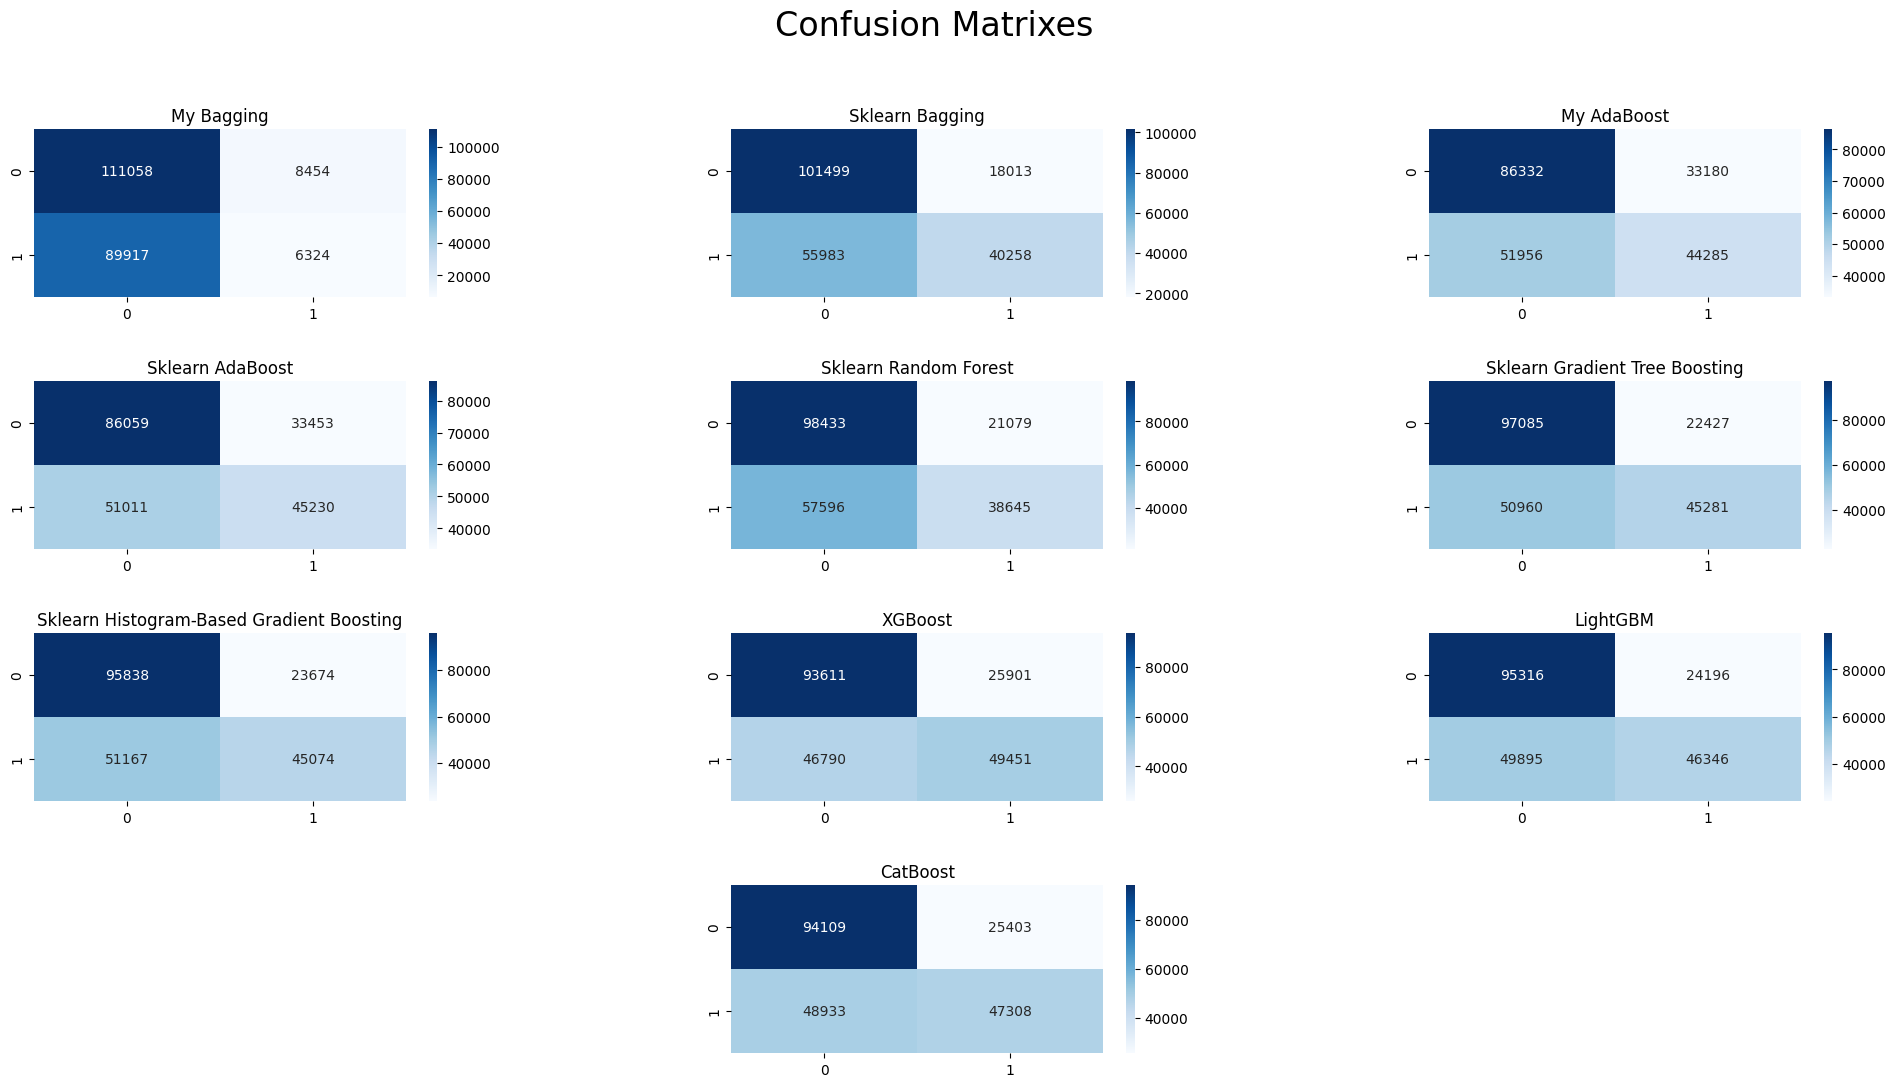

In [49]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(24, 12))

plt.suptitle("Confusion Matrixes", fontsize = 24)
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)

plt.subplot(4, 3, 1)
plt.title("My Bagging")
sns.heatmap(confusion_matrix(y_test, bagging_pred), cmap='Blues', annot = True, fmt = 'd')

plt.subplot(4, 3, 2)
plt.title("Sklearn Bagging")
sns.heatmap(confusion_matrix(y_test, sklearn_bagging_pred), cmap='Blues', annot = True, fmt = 'd')

plt.subplot(4, 3, 3)
plt.title("My AdaBoost")
sns.heatmap(confusion_matrix(y_test, adaboost_pred), cmap='Blues', annot = True, fmt = 'd')

plt.subplot(4, 3, 4)
plt.title("Sklearn AdaBoost")
sns.heatmap(confusion_matrix(y_test, sklearn_adaboost_pred), cmap = 'Blues', annot = True, fmt = 'd')

plt.subplot(4, 3, 5)
plt.title("Sklearn Random Forest")
sns.heatmap(confusion_matrix(y_test, sklearn_rf_pred), cmap = 'Blues', annot = True, fmt = 'd')

plt.subplot(4, 3, 6)
plt.title("Sklearn Gradient Tree Boosting")
sns.heatmap(confusion_matrix(y_test, sklearn_gb_pred), cmap = 'Blues', annot = True, fmt = 'd')

plt.subplot(4, 3, 7)
plt.title("Sklearn Histogram-Based Gradient Boosting")
sns.heatmap(confusion_matrix(y_test, sklearn_hgb_pred), cmap = 'Blues', annot = True, fmt = 'd')

plt.subplot(4, 3, 8)
plt.title("XGBoost")
sns.heatmap(confusion_matrix(y_test, xgboost_pred), cmap = 'Blues', annot = True, fmt = 'd')

plt.subplot(4, 3, 9)
plt.title("LightGBM")
sns.heatmap(confusion_matrix(y_test, lightgbm_pred), cmap = 'Blues', annot = True, fmt = 'd')

plt.subplot(4, 3, 11)
plt.title("CatBoost")
sns.heatmap(confusion_matrix(y_test, catboost_pred), cmap = 'Blues', annot = True, fmt = 'd')

plt.show()

**Выводы**:
- Библиотечные реализации sklearn, XGBoost, LightGBM, CatBoost предсказывают похожие результаты;
- Собственная реализация алгоритма AdaBoost предсказывает результаты, близкие к библиотечным;
- Собственная реализация алгоритма Bagging почти всегда предсказывает класс 0.